In [2]:
import pandas as pd
import os,cv2,math,glob,random
import scipy.io as sio
from math import cos, sin
from pathlib import Path
import pandas as pd
import mediapipe
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import numpy as np


In [3]:
# from sklearn.datasets import load_linnerud
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.svm import SVR
import sklearn.metrics as sm
from sklearn.linear_model import Lasso, RidgeCV, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

from sklearn.multioutput import MultiOutputRegressor
# from sklearn.datasets import make_regression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

In [4]:
def draw_axis(img, pitch,yaw,roll, tdx=None, tdy=None, size = 100):

    yaw = -yaw
    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img

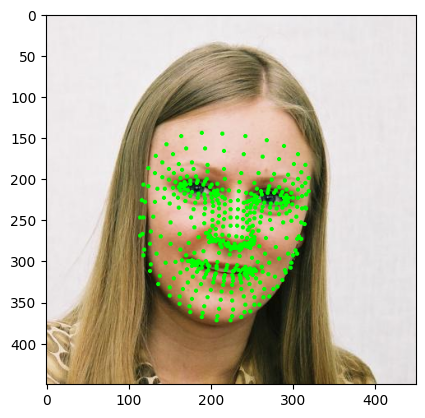

In [5]:
# choosing random image

faceModule = mediapipe.solutions.face_mesh
# loading image and its correspinding mat file
with faceModule.FaceMesh(static_image_mode=True) as faces:
    # loading the image
    image = cv2.imread(r'D:\ITI\ml intro\finale project\AFLW2000\image00045.jpg')
    # processing the face to extract the landmark points (468 point) for each x,y,z
    results = faces.process(image)
    if results.multi_face_landmarks != None: 
      # looping over the faces in the image
      for face in results.multi_face_landmarks:
          for landmark in face.landmark:
              x = landmark.x
              y = landmark.y
              # note: the x and y values are scaled to the their width and height so we will get back their actual value in the image
              shape = image.shape 
              relative_x = int(x * shape[1])
              relative_y = int(y * shape[0])
              # cv2.putText(image, str(relative_y), (int(relative_x),int(relative_y)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0,255,0), 2)
              cv2.circle(image, (relative_x, relative_y), radius=1, color=(0, 255, 0), thickness=2)
      plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

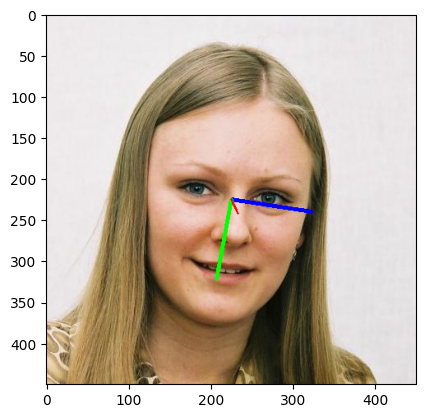

In [6]:

image = cv2.imread(r'D:\ITI\ml intro\finale project\AFLW2000\image00045.jpg')

# loading the mat file to extract the 3 angels of the face (pitch,yaw,roll)
mat_file = sio.loadmat(r'D:\ITI\ml intro\finale project\AFLW2000\image00045.mat')

# extracting the labels 3 angels
pose_para = mat_file["Pose_Para"][0][:3]
pitch = pose_para[0]
yaw = pose_para[1]
roll = pose_para[2]
plt.imshow(draw_axis(cv2.cvtColor(image, cv2.COLOR_BGR2RGB),pitch,yaw,roll))

In [7]:
OG_data_pat= r'D:\ITI\ml intro\finale project\AFLW2000'


Extracting the data

In [8]:
# making img names list
img_names_jpg= []
img_mat_names=[]
for img in os.listdir(OG_data_pat):
    if img.endswith('.jpg'):
        img_names_jpg.append(img)
        img_mat_names.append(img.replace('.jpg','.mat'))

print(img_names_jpg)


['image00002.jpg', 'image00004.jpg', 'image00006.jpg', 'image00008.jpg', 'image00010.jpg', 'image00013.jpg', 'image00014.jpg', 'image00019.jpg', 'image00020.jpg', 'image00021.jpg', 'image00022.jpg', 'image00023.jpg', 'image00026.jpg', 'image00028.jpg', 'image00032.jpg', 'image00035.jpg', 'image00036.jpg', 'image00039.jpg', 'image00040.jpg', 'image00041.jpg', 'image00042.jpg', 'image00043.jpg', 'image00044.jpg', 'image00045.jpg', 'image00046.jpg', 'image00047.jpg', 'image00048.jpg', 'image00049.jpg', 'image00050.jpg', 'image00051.jpg', 'image00052.jpg', 'image00053.jpg', 'image00054.jpg', 'image00055.jpg', 'image00056.jpg', 'image00057.jpg', 'image00058.jpg', 'image00059.jpg', 'image00060.jpg', 'image00061.jpg', 'image00062.jpg', 'image00063.jpg', 'image00064.jpg', 'image00065.jpg', 'image00066.jpg', 'image00067.jpg', 'image00070.jpg', 'image00072.jpg', 'image00074.jpg', 'image00075.jpg', 'image00076.jpg', 'image00077.jpg', 'image00078.jpg', 'image00079.jpg', 'image00080.jpg', 'image000

In [9]:
all_X_Y_list = []
all_names_list=[]

faceModule = mediapipe.solutions.face_mesh


for img in img_names_jpg :
    with faceModule.FaceMesh(static_image_mode=True) as faces:
        x_y_list=[]
        #load the image
        image = cv2.imread(r'D:\ITI\ml intro\finale project\AFLW2000\{}'.format(img))

        #processing the face
        result=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = faces.process(result)
        if results.multi_face_landmarks != None:
            distance = np.sqrt((results.multi_face_landmarks[0].landmark[4].x - results.multi_face_landmarks[0].landmark[152].x)**2 + 
                           (results.multi_face_landmarks[0].landmark[4].y - results.multi_face_landmarks[0].landmark[152].y)**2)
            #looping over each face
            for face in results.multi_face_landmarks:
                #extracting each face landmark
                for landmark in face.landmark:
                    
                    x = (landmark.x - face.landmark[4].x) / distance
                    y = (landmark.y - face.landmark[4].y) / distance

                    #adding the x and y values
                    x_y_list.append(x)
                    x_y_list.append(y)

                all_names_list.append(img)
                all_X_Y_list.append(x_y_list)




making data frame


In [10]:
data_array= np.array(all_X_Y_list)
df=pd.DataFrame(data_array)
df.columns = [f'x{i//2}' if i % 2 == 0 else f'y{i//2}' for i in range(df.shape[1])]
df.insert(0, 'img_name', all_names_list)

df

,img_name,x0,y0,x1,y1,x2,y2,x3,y3,x4,...,x463,y463,x464,y464,x465,y465,x466,y466,x467,y467
0,image00002.jpg,-0.023763,0.318039,-0.006608,0.089623,-0.003660,0.126112,-0.052434,-0.284168,0.0,...,0.334884,-0.658935,0.280286,-0.621762,0.246347,-0.585160,0.847970,-0.725754,0.898440,-0.761255
1,image00004.jpg,0.135413,0.342486,0.007972,0.080383,0.173992,0.176598,0.106438,-0.167729,0.0,...,0.561200,-0.368143,0.502959,-0.343070,0.446501,-0.326301,0.887149,-0.403437,0.937681,-0.428975
2,image00006.jpg,-0.034430,0.295169,-0.001236,0.081680,-0.029556,0.134067,-0.097795,-0.205513,0.0,...,0.121933,-0.470613,0.083552,-0.441696,0.067603,-0.418419,0.488799,-0.515033,0.528681,-0.545838
3,image00008.jpg,0.206932,0.278237,0.038110,0.079996,0.136177,0.103735,-0.085016,-0.232267,0.0,...,0.224827,-0.670649,0.176550,-0.623300,0.141485,-0.583812,0.656935,-0.893202,0.691553,-0.947125
4,image00013.jpg,0.088348,0.338083,0.018155,0.080562,0.046325,0.159415,-0.083514,-0.169729,0.0,...,0.129482,-0.412066,0.090368,-0.385046,0.070017,-0.368895,0.458136,-0.529177,0.493519,-0.545704
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1848,image04345.jpg,-0.099506,0.382301,-0.012532,0.091441,-0.082644,0.161946,-0.118476,-0.237454,0.0,...,0.069193,-0.551914,0.032666,-0.521372,0.023658,-0.495509,0.468623,-0.638878,0.502152,-0.664355
1849,image04348.jpg,-0.114427,0.343321,-0.014927,0.089406,-0.089381,0.143154,-0.106617,-0.248067,0.0,...,0.063317,-0.572273,0.034893,-0.539000,0.030153,-0.510118,0.424921,-0.634113,0.461937,-0.675672
1850,image04356.jpg,-0.100850,0.302593,-0.022522,0.075017,-0.068626,0.153831,-0.028867,-0.183607,0.0,...,0.235676,-0.317613,0.193752,-0.308153,0.170724,-0.299690,0.540392,-0.272583,0.580636,-0.305284
1851,image04358.jpg,-0.056892,0.364116,-0.013459,0.097606,-0.029579,0.156433,-0.064381,-0.279805,0.0,...,0.324608,-0.612609,0.261689,-0.582367,0.225923,-0.553401,0.822230,-0.653332,0.873471,-0.689920


making img mat names list


In [11]:
img_mat_names=[]
for img in all_names_list:
    if img.endswith('.jpg'):
        img_mat_names.append(img.replace('.jpg','.mat'))

print(img_mat_names)

['image00002.mat', 'image00004.mat', 'image00006.mat', 'image00008.mat', 'image00013.mat', 'image00014.mat', 'image00019.mat', 'image00020.mat', 'image00021.mat', 'image00022.mat', 'image00023.mat', 'image00026.mat', 'image00028.mat', 'image00035.mat', 'image00039.mat', 'image00040.mat', 'image00041.mat', 'image00042.mat', 'image00043.mat', 'image00044.mat', 'image00045.mat', 'image00046.mat', 'image00047.mat', 'image00048.mat', 'image00049.mat', 'image00050.mat', 'image00051.mat', 'image00052.mat', 'image00053.mat', 'image00054.mat', 'image00055.mat', 'image00056.mat', 'image00057.mat', 'image00058.mat', 'image00059.mat', 'image00060.mat', 'image00061.mat', 'image00062.mat', 'image00063.mat', 'image00064.mat', 'image00065.mat', 'image00066.mat', 'image00067.mat', 'image00070.mat', 'image00072.mat', 'image00075.mat', 'image00076.mat', 'image00077.mat', 'image00078.mat', 'image00079.mat', 'image00080.mat', 'image00081.mat', 'image00082.mat', 'image00083.mat', 'image00084.mat', 'image000

loading the mat file to extract the 3 angels of the face (pitch,yaw,roll)


In [12]:
pose_list=[]
for img in img_mat_names :
    mat_file = sio.loadmat(r'D:\ITI\ml intro\finale project\AFLW2000\{}'.format(img))
    pose_para = mat_file["Pose_Para"][0][:3]
    pitch=pose_para[0]
    yaw=pose_para[1]
    roll=pose_para[2]
    pose_list.append({
                    "pitch":pitch,
                    "yaw" : yaw,
                    "roll":roll})
    
pose_df =pd.DataFrame(pose_list)


In [13]:
pose_df

,pitch,yaw,roll
0,-0.399231,0.018227,0.085676
1,0.470065,1.189533,0.300959
2,-0.184650,0.881137,-0.236852
3,-0.175379,0.299208,-0.373374
4,-0.026812,0.011965,-0.220662
...,...,...,...
1848,-0.306358,-0.283822,0.038554
1849,-0.367547,-0.429723,0.122791
1850,-0.156035,0.567114,-0.108536
1851,-0.197102,-0.070430,0.105118


merging the two dataframes


In [14]:
all_data_set=df.merge(pose_df,left_index=True,right_index=True)
all_data_set

,img_name,x0,y0,x1,y1,x2,y2,x3,y3,x4,...,y464,x465,y465,x466,y466,x467,y467,pitch,yaw,roll
0,image00002.jpg,-0.023763,0.318039,-0.006608,0.089623,-0.003660,0.126112,-0.052434,-0.284168,0.0,...,-0.621762,0.246347,-0.585160,0.847970,-0.725754,0.898440,-0.761255,-0.399231,0.018227,0.085676
1,image00004.jpg,0.135413,0.342486,0.007972,0.080383,0.173992,0.176598,0.106438,-0.167729,0.0,...,-0.343070,0.446501,-0.326301,0.887149,-0.403437,0.937681,-0.428975,0.470065,1.189533,0.300959
2,image00006.jpg,-0.034430,0.295169,-0.001236,0.081680,-0.029556,0.134067,-0.097795,-0.205513,0.0,...,-0.441696,0.067603,-0.418419,0.488799,-0.515033,0.528681,-0.545838,-0.184650,0.881137,-0.236852
3,image00008.jpg,0.206932,0.278237,0.038110,0.079996,0.136177,0.103735,-0.085016,-0.232267,0.0,...,-0.623300,0.141485,-0.583812,0.656935,-0.893202,0.691553,-0.947125,-0.175379,0.299208,-0.373374
4,image00013.jpg,0.088348,0.338083,0.018155,0.080562,0.046325,0.159415,-0.083514,-0.169729,0.0,...,-0.385046,0.070017,-0.368895,0.458136,-0.529177,0.493519,-0.545704,-0.026812,0.011965,-0.220662
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1848,image04345.jpg,-0.099506,0.382301,-0.012532,0.091441,-0.082644,0.161946,-0.118476,-0.237454,0.0,...,-0.521372,0.023658,-0.495509,0.468623,-0.638878,0.502152,-0.664355,-0.306358,-0.283822,0.038554
1849,image04348.jpg,-0.114427,0.343321,-0.014927,0.089406,-0.089381,0.143154,-0.106617,-0.248067,0.0,...,-0.539000,0.030153,-0.510118,0.424921,-0.634113,0.461937,-0.675672,-0.367547,-0.429723,0.122791
1850,image04356.jpg,-0.100850,0.302593,-0.022522,0.075017,-0.068626,0.153831,-0.028867,-0.183607,0.0,...,-0.308153,0.170724,-0.299690,0.540392,-0.272583,0.580636,-0.305284,-0.156035,0.567114,-0.108536
1851,image04358.jpg,-0.056892,0.364116,-0.013459,0.097606,-0.029579,0.156433,-0.064381,-0.279805,0.0,...,-0.582367,0.225923,-0.553401,0.822230,-0.653332,0.873471,-0.689920,-0.197102,-0.070430,0.105118


saving the data


In [15]:
all_data_set.to_csv("all_data_set.csv",index=False)

In [16]:
all_data_set=pd.read_csv("all_data_set.csv")
all_data_set

,img_name,x0,y0,x1,y1,x2,y2,x3,y3,x4,...,y464,x465,y465,x466,y466,x467,y467,pitch,yaw,roll
0,image00002.jpg,-0.023763,0.318039,-0.006608,0.089623,-0.003660,0.126112,-0.052434,-0.284168,0.0,...,-0.621762,0.246347,-0.585160,0.847970,-0.725754,0.898440,-0.761255,-0.399231,0.018227,0.085676
1,image00004.jpg,0.135413,0.342486,0.007972,0.080383,0.173992,0.176598,0.106438,-0.167729,0.0,...,-0.343070,0.446501,-0.326301,0.887149,-0.403437,0.937681,-0.428975,0.470065,1.189533,0.300959
2,image00006.jpg,-0.034430,0.295169,-0.001236,0.081680,-0.029556,0.134067,-0.097795,-0.205513,0.0,...,-0.441696,0.067603,-0.418419,0.488799,-0.515033,0.528681,-0.545838,-0.184650,0.881137,-0.236852
3,image00008.jpg,0.206932,0.278237,0.038110,0.079996,0.136177,0.103735,-0.085016,-0.232267,0.0,...,-0.623300,0.141485,-0.583812,0.656935,-0.893202,0.691553,-0.947125,-0.175379,0.299208,-0.373374
4,image00013.jpg,0.088348,0.338083,0.018155,0.080562,0.046325,0.159415,-0.083514,-0.169729,0.0,...,-0.385046,0.070017,-0.368895,0.458136,-0.529177,0.493519,-0.545704,-0.026812,0.011965,-0.220662
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1848,image04345.jpg,-0.099506,0.382301,-0.012532,0.091441,-0.082644,0.161946,-0.118476,-0.237454,0.0,...,-0.521372,0.023658,-0.495509,0.468623,-0.638878,0.502152,-0.664355,-0.306358,-0.283822,0.038554
1849,image04348.jpg,-0.114427,0.343321,-0.014927,0.089406,-0.089381,0.143154,-0.106617,-0.248067,0.0,...,-0.539000,0.030153,-0.510118,0.424921,-0.634113,0.461937,-0.675672,-0.367547,-0.429723,0.122791
1850,image04356.jpg,-0.100850,0.302593,-0.022522,0.075017,-0.068626,0.153831,-0.028867,-0.183607,0.0,...,-0.308153,0.170724,-0.299690,0.540392,-0.272583,0.580636,-0.305284,-0.156035,0.567114,-0.108536
1851,image04358.jpg,-0.056892,0.364116,-0.013459,0.097606,-0.029579,0.156433,-0.064381,-0.279805,0.0,...,-0.582367,0.225923,-0.553401,0.822230,-0.653332,0.873471,-0.689920,-0.197102,-0.070430,0.105118


preprocessing the data

In [17]:

pitch=all_data_set['pitch']
yaw=all_data_set['yaw']
roll=all_data_set['roll']

features=all_data_set.drop(['img_name','pitch','yaw','roll'],axis=1)
y=all_data_set[['pitch','yaw','roll']]

In [18]:
features

,x0,y0,x1,y1,x2,y2,x3,y3,x4,y4,...,x463,y463,x464,y464,x465,y465,x466,y466,x467,y467
0,-0.023763,0.318039,-0.006608,0.089623,-0.003660,0.126112,-0.052434,-0.284168,0.0,0.0,...,0.334884,-0.658935,0.280286,-0.621762,0.246347,-0.585160,0.847970,-0.725754,0.898440,-0.761255
1,0.135413,0.342486,0.007972,0.080383,0.173992,0.176598,0.106438,-0.167729,0.0,0.0,...,0.561200,-0.368143,0.502959,-0.343070,0.446501,-0.326301,0.887149,-0.403437,0.937681,-0.428975
2,-0.034430,0.295169,-0.001236,0.081680,-0.029556,0.134067,-0.097795,-0.205513,0.0,0.0,...,0.121933,-0.470613,0.083552,-0.441696,0.067603,-0.418419,0.488799,-0.515033,0.528681,-0.545838
3,0.206932,0.278237,0.038110,0.079996,0.136177,0.103735,-0.085016,-0.232267,0.0,0.0,...,0.224827,-0.670649,0.176550,-0.623300,0.141485,-0.583812,0.656935,-0.893202,0.691553,-0.947125
4,0.088348,0.338083,0.018155,0.080562,0.046325,0.159415,-0.083514,-0.169729,0.0,0.0,...,0.129482,-0.412066,0.090368,-0.385046,0.070017,-0.368895,0.458136,-0.529177,0.493519,-0.545704
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1848,-0.099506,0.382301,-0.012532,0.091441,-0.082644,0.161946,-0.118476,-0.237454,0.0,0.0,...,0.069193,-0.551914,0.032666,-0.521372,0.023658,-0.495509,0.468623,-0.638878,0.502152,-0.664355
1849,-0.114427,0.343321,-0.014927,0.089406,-0.089381,0.143154,-0.106617,-0.248067,0.0,0.0,...,0.063317,-0.572273,0.034893,-0.539000,0.030153,-0.510118,0.424921,-0.634113,0.461937,-0.675672
1850,-0.100850,0.302593,-0.022522,0.075017,-0.068626,0.153831,-0.028867,-0.183607,0.0,0.0,...,0.235676,-0.317613,0.193752,-0.308153,0.170724,-0.299690,0.540392,-0.272583,0.580636,-0.305284
1851,-0.056892,0.364116,-0.013459,0.097606,-0.029579,0.156433,-0.064381,-0.279805,0.0,0.0,...,0.324608,-0.612609,0.261689,-0.582367,0.225923,-0.553401,0.822230,-0.653332,0.873471,-0.689920


In [19]:
# using pca
pca = PCA(n_components=6)
pca.fit(features)
x_pca = pca.transform(features)
x_pca

array([[ 1.01421085e+00, -2.67158786e+00, -5.47988957e+00,
         3.07224145e-01,  3.68607428e-02, -1.44394050e-01],
       [ 1.02251870e+01, -5.73521304e-01,  3.02772208e+00,
         1.04015236e+00, -1.34592038e+00,  5.45655311e-01],
       [-2.27360168e+00, -1.54743876e-01, -1.27631028e+00,
        -6.72726616e-01,  5.69454324e-01,  2.66756477e-03],
       ...,
       [-1.15639615e+00, -3.34327905e+00,  1.50436521e+00,
         8.03280195e-02,  2.33853238e-01, -2.91810183e-02],
       [-4.16354510e-01, -2.85392350e+00, -4.90583714e+00,
        -6.55389673e-01, -8.78443642e-02,  3.89192228e-02],
       [-8.56309226e-01,  1.50334855e-01,  5.28485696e-01,
        -1.17766492e+00, -4.99522472e-01, -9.03353395e-02]])

In [20]:
print(sum(pca.explained_variance_ratio_))

0.9942595108282997


In [21]:
print(pca.explained_variance_)

[28.36416688 10.22472441  9.62856055  2.42103934  0.73551339  0.22233512]


split the data into train and test


In [22]:
# 90% train 10% test
X_train_pitch, X_test_pitch, y_train_pitch, y_test_pitch = train_test_split(x_pca, pitch, test_size=0.1, random_state=42)
X_train_yaw, X_test_yaw, y_train_yaw, y_test_yaw = train_test_split(x_pca, yaw, test_size=0.1, random_state=42)
X_train_roll, X_test_roll, y_train_roll, y_test_roll = train_test_split(x_pca, roll, test_size=0.1, random_state=42)

In [23]:
import xgboost
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error


using grid search to find the best parameters

In [24]:
#optimizing by grid search
# Create the parameter grid based on the results of random search 
param_grid = {'n_estimators': np.arange(7,15,2),'max_depth': np.arange(1,10,2),'learning_rate': np.arange(0.5,1,0.2)}
#grid search on the patch
grid_search = XGBRegressor(random_state=0,verbosity=0)
grid_search_pitch = GridSearchCV(estimator = grid_search, param_grid = param_grid)
grid_search_pitch.fit(X_train_pitch, y_train_pitch)
best_grid_pitch = grid_search_pitch.best_estimator_
print(best_grid_pitch)
print("train error :",mean_absolute_error(grid_search_pitch.predict(X_train_pitch),y_train_pitch))
print("validation error :",mean_absolute_error(grid_search_pitch.predict(X_test_pitch),y_test_pitch))

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.5, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=1, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=11, n_jobs=None,
             num_parallel_tree=None, random_state=0, ...)
train error : 0.15166517911979707
validation error : 0.12938427833730096


In [25]:
#grid search on the yaw
grid_search_yaw = GridSearchCV(estimator = grid_search, param_grid = param_grid)
grid_search_yaw.fit(X_train_yaw, y_train_yaw)
best_grid_yaw = grid_search_yaw.best_estimator_
print(best_grid_yaw)
print("train error :",mean_absolute_error(grid_search_yaw.predict(X_train_yaw),y_train_yaw))
print("validation error :",mean_absolute_error(grid_search_yaw.predict(X_test_yaw),y_test_yaw))

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.5, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=11, n_jobs=None,
             num_parallel_tree=None, random_state=0, ...)
train error : 0.07873221238364082
validation error : 0.087381650792918


In [26]:
#grid search on the roll
grid_search_roll = GridSearchCV(estimator = grid_search, param_grid = param_grid)
grid_search_roll.fit(X_train_roll, y_train_roll)
best_grid_roll = grid_search_roll.best_estimator_
print(best_grid_roll)
print("train error :",mean_absolute_error(grid_search_roll.predict(X_train_roll),y_train_roll))
print("validation error :",mean_absolute_error(grid_search_roll.predict(X_test_roll),y_test_roll))

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.5, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=1, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=7, n_jobs=None,
             num_parallel_tree=None, random_state=0, ...)
train error : 0.14578400277163162
validation error : 0.14732357789011252


SVR

pitch

In [27]:
svr_model_pitch = SVR(kernel='rbf')
svr_model_pitch.fit(X_train_pitch,y_train_pitch)
svr_model_pitch.predict(X_test_pitch)

r2_model_pitch = mean_absolute_error(y_test_pitch, svr_model_pitch.predict(X_test_pitch))

print(r2_model_pitch)

0.08222233404051055


yaw

In [28]:
svr_model_yaw = SVR(kernel='rbf')
svr_model_yaw.fit(X_train_yaw,y_train_yaw)
svr_model_yaw.predict(X_test_yaw)

r2_model_yaw = mean_absolute_error(y_test_yaw, svr_model_yaw.predict(X_test_yaw))

print(r2_model_yaw)

0.06023338564338826


roll

In [29]:
svr_model_roll = SVR(kernel='rbf')
svr_model_roll.fit(X_train_roll,y_train_roll)
svr_model_roll.predict(X_test_roll)

r2_model_roll = mean_absolute_error(y_test_roll, svr_model_roll.predict(X_test_roll))

print(r2_model_roll)

0.06263603008376478


In [30]:
# save the model 
import joblib

filename = 'pitch_model.sav'
joblib.dump(svr_model_pitch, filename)

filename = 'yaw_model.sav'
joblib.dump(svr_model_yaw, filename)

filename = 'roll_model.sav'
joblib.dump(svr_model_roll, filename)

['roll_model.sav']

In [31]:
# load the model from disk
loaded_model_pitch = joblib.load('pitch_model.sav')
loaded_model_yaw = joblib.load('yaw_model.sav')
loaded_model_roll = joblib.load('roll_model.sav')

test the model

on a video 

In [37]:
import os

face_mesh = mediapipe.solutions.face_mesh.FaceMesh(static_image_mode=True)

video_path = r'D:\ITI\ml intro\finale project\kareemabdelaziz.mp4'

# Specify filenames for the main video and the img_axis video
main_video_filename = 'kareemNose.mp4'
img_axis_video_filename = 'kareemNose_img_axis_video.mp4'

# Combine the filenames with the current working directory
main_video_output_path = os.path.join(os.getcwd(), main_video_filename)
img_axis_video_output_path = os.path.join(os.getcwd(), img_axis_video_filename)

# Create VideoWriters for the main video and img_axis video
main_video_writer = cv2.VideoWriter(main_video_output_path, cv2.VideoWriter_fourcc(*'mp4v'), 30, (640, 480))
img_axis_video_writer = cv2.VideoWriter(img_axis_video_output_path, cv2.VideoWriter_fourcc(*'mp4v'), 30, (640, 480))

cap = cv2.VideoCapture(video_path)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    new_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    results = face_mesh.process(new_frame)
    frames_list = []
    if results.multi_face_landmarks:
        for face in results.multi_face_landmarks:
            nose = results.multi_face_landmarks[0].landmark[4]
            distance = np.sqrt((results.multi_face_landmarks[0].landmark[4].x - results.multi_face_landmarks[0].landmark[152].x)**2 +
                               (results.multi_face_landmarks[0].landmark[4].y - results.multi_face_landmarks[0].landmark[152].y)**2)
            for landmark in face.landmark:
                x = (landmark.x - face.landmark[4].x) / distance
                y = (landmark.y - face.landmark[4].y) / distance

                frames_list.append(x)
                frames_list.append(y)

        frames_array = np.array(frames_list).reshape(1, -1)
        frames_array[:, ::2] -= frames_array[:, 8]
        frames_array[:, 1::2] -= frames_array[:, 9]

        pca_img = pca.transform(frames_array)

        pred_pitch = svr_model_pitch.predict(pca_img)
        pred_yaw = svr_model_yaw.predict(pca_img)
        pred_roll = svr_model_roll.predict(pca_img)

        # draw axis
        img_axis = draw_axis(cv2.cvtColor(new_frame, cv2.COLOR_BGR2RGB), pred_pitch[0], pred_yaw[0], pred_roll[0],
                             tdx=nose.x * new_frame.shape[1], tdy=nose.y * new_frame.shape[0])
        cv2.imshow('img_axis', img_axis)
        img_axis = cv2.resize(img_axis, (640, 480))
        img_axis_video_writer.write(img_axis)

    else:
        cv2.imshow('img_axis', cv2.cvtColor(new_frame, cv2.COLOR_BGR2RGB))
        img_axis_video_writer.write(cv2.cvtColor(new_frame, cv2.COLOR_BGR2RGB))

    main_video_writer.write(cv2.cvtColor(new_frame, cv2.COLOR_BGR2RGB))

    if cv2.waitKey(1) & 0xFF == 27:  # Press 'Esc' to exit
        break

cap.release()
main_video_writer.release()
img_axis_video_writer.release()
cv2.destroyAllWindows()
face_mesh.close()


image

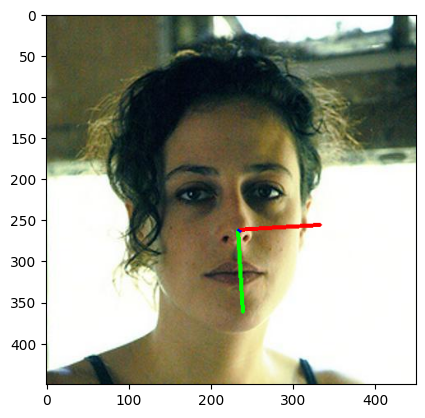

In [36]:
import cv2
import mediapipe as mp
import numpy as np

# Initialize FaceMesh instance
face_mesh = mp.solutions.face_mesh.FaceMesh(static_image_mode=True)

# Image paths
image_path = r'D:\ITI\ml intro\finale project\AFLW2000/image04375.jpg'
output_path = r'D:\ITI\ml intro\finale project\test.jpg'

# Read the image
frame = cv2.imread(image_path)
new_frame = cv2.resize(frame, (450, 450))
# new_frame = cv2.cvtColor(new_frame, cv2.COLOR_BGR2RGB)

# Process the face mesh
results = face_mesh.process(new_frame)

frames_list = []
if results.multi_face_landmarks:
    for face in results.multi_face_landmarks:
        nose = results.multi_face_landmarks[0].landmark[4]
        distance = np.sqrt((results.multi_face_landmarks[0].landmark[4].x - results.multi_face_landmarks[0].landmark[152].x)**2 + 
                           (results.multi_face_landmarks[0].landmark[4].y - results.multi_face_landmarks[0].landmark[152].y)**2)
        for landmark in face.landmark:
            x = (landmark.x - face.landmark[4].x) / distance
            y = (landmark.y - face.landmark[4].y) / distance
            frames_list.append(x)
            frames_list.append(y)

    frames_array = np.array(frames_list).reshape(1, -1)
    frames_array[:, ::2] -= frames_array[:, 8]
    frames_array[:, 1::2] -= frames_array[:, 9]

    # Make predictions 
    pca_img = pca.transform(frames_array)

    pred_pitch=svr_model_pitch.predict(pca_img)
    pred_yaw=svr_model_roll.predict(pca_img)
    pred_roll=svr_model_yaw.predict(pca_img)

    # Draw axis (if needed)
    img_axis = draw_axis(new_frame, pred_pitch[0], pred_yaw[0], pred_roll[0], tdx=nose.x*new_frame.shape[1], tdy=nose.y*new_frame.shape[0])
    # cv2.imshow('img_axis', img_axis)

else:
    print("No face detected.")

# Save the processed image
cv2.imwrite(output_path, new_frame)

# Close FaceMesh instance
face_mesh.close()



# Display the processed image
cv2.imshow('Face Mesh', new_frame)
cv2.waitKey(0)
cv2.destroyAllWindows()
#dislay the image
plt.imshow(cv2.cvtColor(new_frame, cv2.COLOR_BGR2RGB))


life stream video

In [34]:


# Initialize Face Mesh
face_mesh = mediapipe.solutions.face_mesh.FaceMesh(static_image_mode=False, max_num_faces=1)

# Open Webcam
cap = cv2.VideoCapture(0)  # 0 represents the default camera (you can change it if needed)

# Set up Video Writer
vid_ext = cv2.VideoWriter_fourcc(*'mp4v')
output_path = r'D:\ITI\ml intro\finale project\livevideo.mp4'
output_video = cv2.VideoWriter(output_path, vid_ext, 30, (int(cap.get(3)), int(cap.get(4))))

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Resize and convert frame to RGB
    new_frame = cv2.resize(frame, (450, 450))
    # new_frame = cv2.cvtColor(new_frame, cv2.COLOR_BGR2RGB)

    # Process frame with Face Mesh
    results = face_mesh.process(new_frame)

    frames_list = []
    if results.multi_face_landmarks:
        for face in results.multi_face_landmarks:
            nose = results.multi_face_landmarks[0].landmark[4]
            distance = np.sqrt((results.multi_face_landmarks[0].landmark[4].x - results.multi_face_landmarks[0].landmark[152].x)**2 +
                               (results.multi_face_landmarks[0].landmark[4].y - results.multi_face_landmarks[0].landmark[152].y)**2)

            for landmark in face.landmark:
                x = (landmark.x - face.landmark[4].x) / distance
                y = (landmark.y - face.landmark[4].y) / distance

                frames_list.append(x)
                frames_list.append(y)

        frames_array = np.array(frames_list).reshape(1, -1)
        frames_array[:, ::2] -= frames_array[:, 8]
        frames_array[:, 1::2] -= frames_array[:, 9]

        # PCA and Prediction 
        pca_img = pca.transform(frames_array)
        pred_pitch = svr_model_pitch.predict(pca_img)
        pred_yaw = svr_model_yaw.predict(pca_img)
        pred_roll = svr_model_roll.predict(pca_img)

        # Draw axis
        img_axis = draw_axis(new_frame, pred_pitch[0], pred_yaw[0], pred_roll[0], tdx=nose.x*new_frame.shape[1], tdy=nose.y*new_frame.shape[0])
        cv2.imshow('img_axis', img_axis)
        img_axis = cv2.resize(img_axis, (450, 450))
        output_video.write(img_axis)

    else:
        cv2.imshow('img_axis', new_frame)
        output_video.write(new_frame)

    # Press 'Esc' to exit
    if cv2.waitKey(1) & 0xFF == 27:
        break

# Release resources
cap.release()
output_video.release()
cv2.destroyAllWindows()
face_mesh.close()
